# Spatial statistics: from global to local and univariate to multivariate

In [ ]:
#!pip install cenpy
#!pip install python-Levenshtein

## Exercise 1: imports (2 points) 
<div class="alert alert-block alert-success">
       Exercise 1: There are eight instances of 'xxx' below in the second code block of import statements. Replace each instance with the keywords for the appropriate modules, submodules, classes or functions. You should be able to run the entire cell of code without any errors. The comments on each line provide additional clues as to what needs to be imported. Hint: You can find examples for each throughout the demonstration notebooks.

</div>

In [100]:
#Foundational libraries
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import geopandas as gp
import cenpy as cen
import matplotlib.pyplot as plt
import matplotlib as mpl
import shapely
import seaborn
%matplotlib inline

#Needed for spatial statistics
import libpysal.weights as sw #spatial weights
from esda.moran import Moran, Moran_Local #global & local Moran's I
import spreg #spatial regression module
from mgwr.gwr import GWR, MGWR #GWR & MGWR constructors
from mgwr.sel_bw import Sel_BW #bandwidth selection constructor
from mgwr.utils import compare_surfaces, truncate_colormap, shift_colormap
from splot.esda import lisa_cluster, plot_local_autocorrelation

## Exercise 2: Loading and preparing data (6 points) 


In [2]:
fname = 'crude_16.csv'
obesity = pd.read_csv(fname, encoding='latin1', header=2)

In [3]:
obesity.head()

County    State  CountyFIPS Percentage Lower Limit  Upper Limit
0  Autauga County  Alabama      1001.0       33.3        27.5         39.5
1  Baldwin County  Alabama      1003.0         31        28.2           34
2  Barbour County  Alabama      1005.0       41.7        34.5         49.2
3     Bibb County  Alabama      1007.0       37.6        30.1           46
4   Blount County  Alabama      1009.0       33.8        28.2         39.9

In [4]:
obesity.tail()

County    State  CountyFIPS  \
3222                                       Teton County  Wyoming     56039.0   
3223                                       Uinta County  Wyoming     56041.0   
3224                                    Washakie County  Wyoming     56043.0   
3225                                      Weston County  Wyoming     56045.0   
3226  US Diabetes Surveillance System; www.cdc.gov/d...      NaN         NaN   

     Percentage Lower Limit  Upper Limit  
3222       12.4         9.8         15.5  
3223       35.8        30.6         40.4  
3224       28.8        23.4         34.8  
3225       33.3          28         39.1  
3226        NaN         NaN          NaN

<div class="alert alert-block alert-success">
       Exercise 2.1: Drop The last row of the obesity dataframe that has the 'NaN' values. You should be able to check the tail of the obesity dataframe afterward and see the row is removed.

</div>

In [5]:
# drop the NaN values and reassign the results to the obesity variable
obesity.drop(obesity.tail(1).index,inplace=True)

In [6]:
obesity.tail()

County    State  CountyFIPS Percentage Lower Limit  \
3221  Sweetwater County  Wyoming     56037.0       29.8        26.2   
3222       Teton County  Wyoming     56039.0       12.4         9.8   
3223       Uinta County  Wyoming     56041.0       35.8        30.6   
3224    Washakie County  Wyoming     56043.0       28.8        23.4   
3225      Weston County  Wyoming     56045.0       33.3          28   

      Upper Limit  
3221         33.3  
3222         15.5  
3223         40.4  
3224         34.8  
3225         39.1

<div class="alert alert-block alert-success">
       Exercise 2.2: Convert the 'CountyFIPS' column from float to integer to remove the decimal and then convert from integer to a string.

</div>

In [7]:
obesity.dtypes

County           object
State            object
CountyFIPS      float64
Percentage       object
Lower Limit      object
 Upper Limit     object
dtype: object

In [8]:
# convert 'CountyFIPS
obesity['CountyFIPS']=obesity['CountyFIPS'].astype(int)

In [9]:
obesity.head()

County    State  CountyFIPS Percentage Lower Limit  Upper Limit
0  Autauga County  Alabama        1001       33.3        27.5         39.5
1  Baldwin County  Alabama        1003         31        28.2           34
2  Barbour County  Alabama        1005       41.7        34.5         49.2
3     Bibb County  Alabama        1007       37.6        30.1           46
4   Blount County  Alabama        1009       33.8        28.2         39.9

In [10]:
# convert CountyFIPS to standard five-digit format
obesity['CountyFIPS']=obesity['CountyFIPS'].apply(lambda x: '{0:0>5}'.format(x))
obesity.head()

County    State CountyFIPS Percentage Lower Limit  Upper Limit
0  Autauga County  Alabama      01001       33.3        27.5         39.5
1  Baldwin County  Alabama      01003         31        28.2           34
2  Barbour County  Alabama      01005       41.7        34.5         49.2
3     Bibb County  Alabama      01007       37.6        30.1           46
4   Blount County  Alabama      01009       33.8        28.2         39.9

<div class="alert alert-block alert-success">
       Exercise 2.3: We'll use cenpy to collect variables from the 2016 american community survey (5-year estimates). Then create a 'CountyFIPS' column in the data dataframe by combining the 'state' and 'county' columns. In order to match the obesity dataframe, convert the 'state' column to first to an integer and then to a string before concatenating with 'county' converted to a string. Finally, merge the obesity and data dataframes on the 'CountyFIPS' column and reassign the results to the obesity variable. 

</div>

In [11]:
# establish connection
con = cen.remote.APIConnection('ACSDT5Y2016')
con

Connection to ACS 5-Year Detailed Tables (ID: https://api.census.gov/data/id/ACSDT5Y2016)

In [12]:
#variable definitions

# B25099_001E = median household income 
# B16010_041E = total population w/ bachelor degree or higher
# B22005B_002E = individuals enrolled in Supplemental Nutrition Assistance Program (SNAP) within last 12 months
# B03002_012E = total population identifying as Hispanic
# C27001G_007E = individuals 18-64 w/o health insurance
# B25026_001E = total population

cols = ['B25099_001E', 'B16010_041E', 'B22005B_002E', 'B03002_012E', 'C27001G_007E', 'B25026_001E']
cols

['B25099_001E',
 'B16010_041E',
 'B22005B_002E',
 'B03002_012E',
 'C27001G_007E',
 'B25026_001E']

In [13]:
# make query

data = con.query(cols, geo_unit='county')

In [14]:
data.head()

B25099_001E B16010_041E B22005B_002E B03002_012E C27001G_007E B25026_001E  \
0       39125        1390            0         304           62       18178   
1       77330       49705         1231       15082          543      230398   
2       43911        1372            0         235           41       15365   
3       48929        2851          181        2201           24       21836   
4       51274         260            0          33           14        2004   

  state county  
0    29    229  
1    29    047  
2    29    065  
3    29    195  
4    29    227

In [15]:
data.dtypes

B25099_001E     object
B16010_041E     object
B22005B_002E    object
B03002_012E     object
C27001G_007E    object
B25026_001E     object
state           object
county          object
dtype: object

In [16]:
# convert ['state'] to dtype string
data['state'] = data['state'].astype(int).astype(str)

In [17]:
data.dtypes

B25099_001E     object
B16010_041E     object
B22005B_002E    object
B03002_012E     object
C27001G_007E    object
B25026_001E     object
state           object
county          object
dtype: object

In [18]:
data.head()

B25099_001E B16010_041E B22005B_002E B03002_012E C27001G_007E B25026_001E  \
0       39125        1390            0         304           62       18178   
1       77330       49705         1231       15082          543      230398   
2       43911        1372            0         235           41       15365   
3       48929        2851          181        2201           24       21836   
4       51274         260            0          33           14        2004   

  state county  
0    29    229  
1    29    047  
2    29    065  
3    29    195  
4    29    227

In [19]:
# create 'CountyFIPS' column in data dataframe
data['CountyFIPS'] = data['state'] + data['county'].astype(str)
data.head()

B25099_001E B16010_041E B22005B_002E B03002_012E C27001G_007E B25026_001E  \
0       39125        1390            0         304           62       18178   
1       77330       49705         1231       15082          543      230398   
2       43911        1372            0         235           41       15365   
3       48929        2851          181        2201           24       21836   
4       51274         260            0          33           14        2004   

  state county CountyFIPS  
0    29    229      29229  
1    29    047      29047  
2    29    065      29065  
3    29    195      29195  
4    29    227      29227

In [20]:
# merge obesity and data dataframes on 'CountyFIPS'
obesity_data = pd.merge(obesity, data, on='CountyFIPS')
obesity_data.head()

County                 State CountyFIPS Percentage  \
0           Kent County              Delaware      10001       35.4   
1     New Castle County              Delaware      10003       28.7   
2         Sussex County              Delaware      10005       32.9   
3  District Of Columbia  District of Columbia      11001       23.5   
4        Alachua County               Florida      12001       26.7   

  Lower Limit  Upper Limit B25099_001E B16010_041E B22005B_002E B03002_012E  \
0        33.7         37.1       65809       25985         3421       11326   
1        27.2         30.2       81230      132263        10386       51912   
2        31.3         34.6       61216       37073         3155       19424   
3        22.6         24.4      118203      256316        36809       69106   
4        24.2         29.6       66271       63784         4783       23079   

  C27001G_007E B25026_001E state county  
0          406      166252    10    001  
1          706      534967    10    003  
2          228      208324    10    005  
3          617      619042    11    001  
4         1013      239917    12    001

<div class="alert alert-block alert-success">
       Exercise 2.4: Read in the counties.geojson file countaining county boundary geometries. Then create a 'CountyFIPS' column as was done above using the 'STATE' and 'COUNTY' columns in the countries dataframe. Finally, merge the obesity dataframe into the counties dataframe, remove Hawaii, Alaska, and Puerto Rico, and plot the continental states. 

</div>

In [21]:
#This is how county geom was originally obtained - takes a good 10/15 min
#con.set_mapservice('tigerWMS_ACS2016')
#geodata = con.mapservice.query(layer=84, where='OID > 0')
#geodata.to_file('counties.shp')

# read in counties boundary file
counties = gp.read_file('zip://counties.zip')

In [22]:
counties.head()

MTFCC             OID  GEOID STATE COUNTY  COUNTYNS   BASENAME  \
0  G4020  27556109873712  30015    30    015  01719619   Chouteau   
1  G4020  27556119101045  31017    31    017  00835830      Brown   
2  G4020  27556136791559  47013    47    013  01639728   Campbell   
3  G4020  27556177452845  37069    37    069  01008553   Franklin   
4  G4020  27556165683114  24510    24    510  01702381  Baltimore   

              NAME LSADC FUNCSTAT COUNTYCC     AREALAND  AREAWATER  OBJECTID  \
0  Chouteau County    06        A       H1  10288778621   62611691         1   
1     Brown County    06        A       H1   3163296263    9814399         2   
2  Campbell County    06        A       H1   1243685301   46425148         3   
3  Franklin County    06        A       H1   1273761672    7173998         4   
4   Baltimore city    25        F       C7    209649356   28758714         5   

       CENTLAT       CENTLON     INTPTLAT      INTPTLON  \
0  +47.8806543  -110.4354426  +47.8868343  -110.4362004   
1  +42.4294932  -099.9293903  +42.3595618  -099.9239198   
2  +36.4034350  -084.1494562  +36.4015922  -084.1592495   
3  +36.0827221  -078.2857435  +36.0882406  -078.2830903   
4  +39.3009639  -076.6106288  +39.3000324  -076.6104761   

                                            geometry  
0  POLYGON ((-12315494.121 6143488.405, -12315265...  
1  POLYGON ((-11111319.574 5272855.550, -11111155...  
2  POLYGON ((-9386705.591 4354814.516, -9386736.2...  
3  POLYGON ((-8728718.456 4324164.707, -8728364.7...  
4  POLYGON ((-8539486.120 4774265.314, -8539486.0...

In [23]:
counties.dtypes

MTFCC          object
OID             int64
GEOID          object
STATE          object
COUNTY         object
COUNTYNS       object
BASENAME       object
NAME           object
LSADC          object
FUNCSTAT       object
COUNTYCC       object
AREALAND        int64
AREAWATER       int64
OBJECTID        int64
CENTLAT        object
CENTLON        object
INTPTLAT       object
INTPTLON       object
geometry     geometry
dtype: object

In [24]:
# create 'CountyFIPS' column
counties['CountyFIPS'] = counties['STATE'] + counties['COUNTY']
counties.head()

MTFCC             OID  GEOID STATE COUNTY  COUNTYNS   BASENAME  \
0  G4020  27556109873712  30015    30    015  01719619   Chouteau   
1  G4020  27556119101045  31017    31    017  00835830      Brown   
2  G4020  27556136791559  47013    47    013  01639728   Campbell   
3  G4020  27556177452845  37069    37    069  01008553   Franklin   
4  G4020  27556165683114  24510    24    510  01702381  Baltimore   

              NAME LSADC FUNCSTAT COUNTYCC     AREALAND  AREAWATER  OBJECTID  \
0  Chouteau County    06        A       H1  10288778621   62611691         1   
1     Brown County    06        A       H1   3163296263    9814399         2   
2  Campbell County    06        A       H1   1243685301   46425148         3   
3  Franklin County    06        A       H1   1273761672    7173998         4   
4   Baltimore city    25        F       C7    209649356   28758714         5   

       CENTLAT       CENTLON     INTPTLAT      INTPTLON  \
0  +47.8806543  -110.4354426  +47.8868343  -110.4362004   
1  +42.4294932  -099.9293903  +42.3595618  -099.9239198   
2  +36.4034350  -084.1494562  +36.4015922  -084.1592495   
3  +36.0827221  -078.2857435  +36.0882406  -078.2830903   
4  +39.3009639  -076.6106288  +39.3000324  -076.6104761   

                                            geometry CountyFIPS  
0  POLYGON ((-12315494.121 6143488.405, -12315265...      30015  
1  POLYGON ((-11111319.574 5272855.550, -11111155...      31017  
2  POLYGON ((-9386705.591 4354814.516, -9386736.2...      47013  
3  POLYGON ((-8728718.456 4324164.707, -8728364.7...      37069  
4  POLYGON ((-8539486.120 4774265.314, -8539486.0...      24510

In [25]:
# merge the obesity dataframe into the counties dataframe
counties = pd.merge(counties, obesity_data, on='CountyFIPS')
counties.head()

MTFCC             OID  GEOID STATE COUNTY  COUNTYNS   BASENAME  \
0  G4020  27556109873712  30015    30    015  01719619   Chouteau   
1  G4020  27556119101045  31017    31    017  00835830      Brown   
2  G4020  27556136791559  47013    47    013  01639728   Campbell   
3  G4020  27556177452845  37069    37    069  01008553   Franklin   
4  G4020  27556165683114  24510    24    510  01702381  Baltimore   

              NAME LSADC FUNCSTAT  ... Lower Limit   Upper Limit  B25099_001E  \
0  Chouteau County    06        A  ...        22.4          36.5        49899   
1     Brown County    06        A  ...          32          45.3        44737   
2  Campbell County    06        A  ...        25.1          41.1        40758   
3  Franklin County    06        A  ...        27.1          45.8        52626   
4   Baltimore city    25        F  ...        32.8          37.1        63187   

   B16010_041E B22005B_002E B03002_012E C27001G_007E B25026_001E state county  
0          963            0         124           13        5729    30    015  
1          428            0          31            6        2972    31    017  
2         3041           16         484           55       39488    47    013  
3         8805         1947        4969          102       61328    37    069  
4       125423        52203       29537          823      596742    24    510  

[5 rows x 33 columns]

<AxesSubplot:>

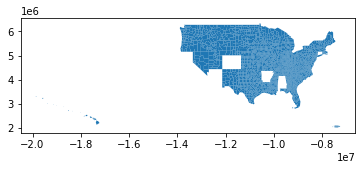

In [26]:
counties.plot()

In [27]:
# remove Hawaii, Alaska, and Puerto Rico
no_AK = (counties['State'] != 'Alaska') 
no_HI = (counties['State'] != 'Hawaii') 
no_PR = (counties['State'] != 'Puerto Rico')
counties = counties[no_AK & no_HI & no_PR]

<AxesSubplot:>

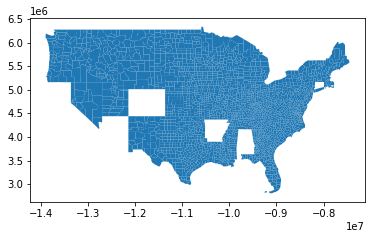

In [28]:
counties.plot()

## Exercise 3: Mapping and exploratory spatial data analysis (4 points)

In [29]:
# convert explanatory variables to percentages
counties['B16010_041E'] = counties['B16010_041E'].astype(float) / counties['B25026_001E'].astype(float)
counties['B22005B_002E'] = counties['B22005B_002E'].astype(float) / counties['B25026_001E'].astype(float)
counties['B03002_012E'] = counties['B03002_012E'].astype(float) / counties['B25026_001E'].astype(float)
counties['C27001G_007E'] = counties['C27001G_007E'].astype(float) / counties['B25026_001E'].astype(float)

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [30]:
counties.head()

MTFCC             OID  GEOID STATE COUNTY  COUNTYNS   BASENAME  \
0  G4020  27556109873712  30015    30    015  01719619   Chouteau   
1  G4020  27556119101045  31017    31    017  00835830      Brown   
2  G4020  27556136791559  47013    47    013  01639728   Campbell   
3  G4020  27556177452845  37069    37    069  01008553   Franklin   
4  G4020  27556165683114  24510    24    510  01702381  Baltimore   

              NAME LSADC FUNCSTAT  ... Lower Limit   Upper Limit  B25099_001E  \
0  Chouteau County    06        A  ...        22.4          36.5        49899   
1     Brown County    06        A  ...          32          45.3        44737   
2  Campbell County    06        A  ...        25.1          41.1        40758   
3  Franklin County    06        A  ...        27.1          45.8        52626   
4   Baltimore city    25        F  ...        32.8          37.1        63187   

   B16010_041E B22005B_002E B03002_012E C27001G_007E B25026_001E state county  
0     0.168092     0.000000    0.021644     0.002269        5729    30    015  
1     0.144011     0.000000    0.010431     0.002019        2972    31    017  
2     0.077011     0.000405    0.012257     0.001393       39488    47    013  
3     0.143572     0.031747    0.081023     0.001663       61328    37    069  
4     0.210180     0.087480    0.049497     0.001379      596742    24    510  

[5 rows x 33 columns]

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

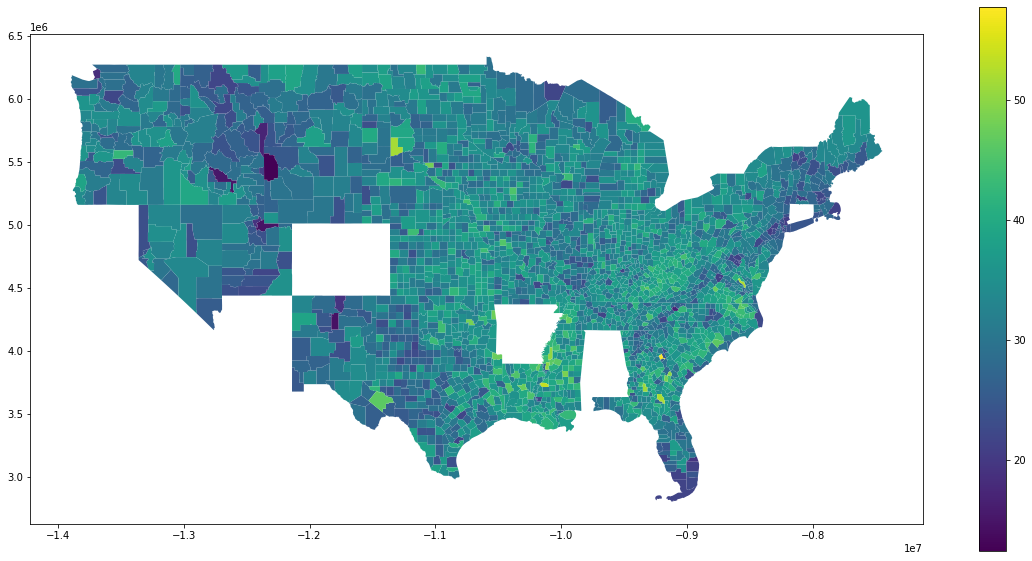

In [31]:
# plot obesity percentages (dependent variable)
counties['Percentage'] = counties['Percentage'].astype(float)
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('Percentage', legend=True, ax=ax)

<AxesSubplot:>

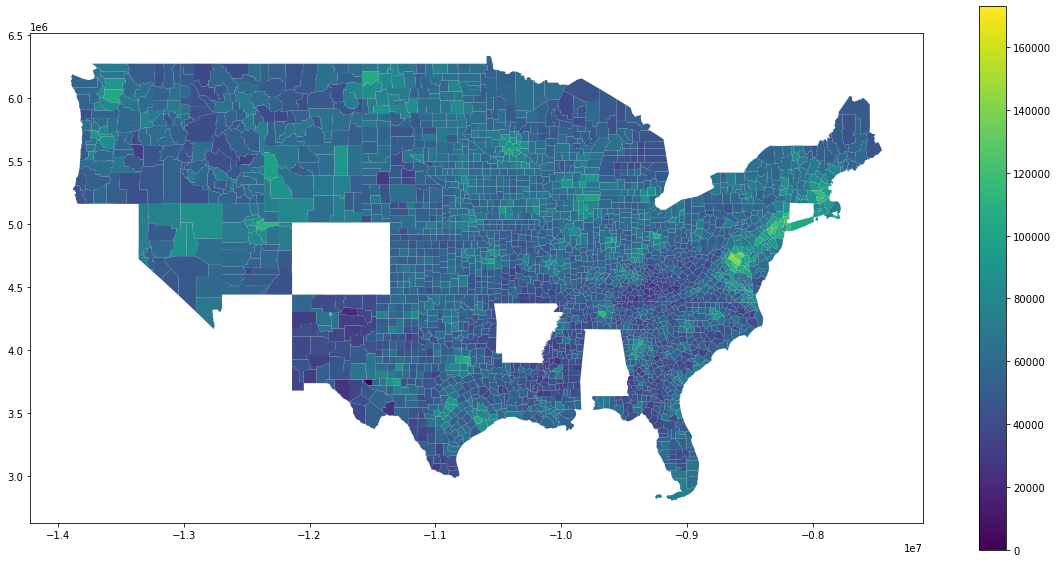

In [32]:
# plot median income
counties['B25099_001E'] = counties['B25099_001E'].astype(float)
counties.loc[(counties['B25099_001E'] < 0), 'B25099_001E' ] = 0
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('B25099_001E', legend=True, ax=ax)

<AxesSubplot:>

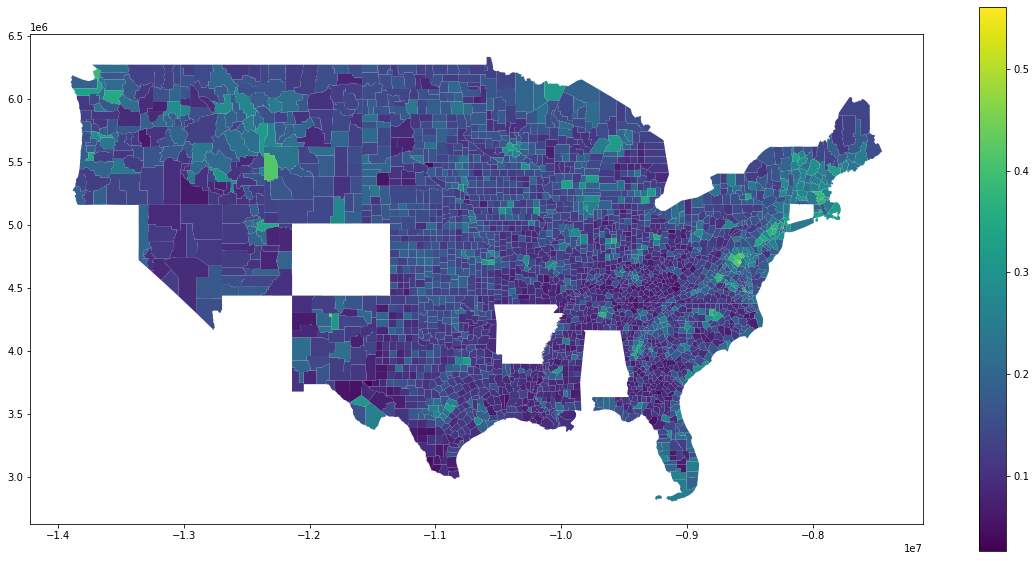

In [33]:
# plot percent w/ bachelor+
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('B16010_041E', legend=True, ax=ax)

<AxesSubplot:>

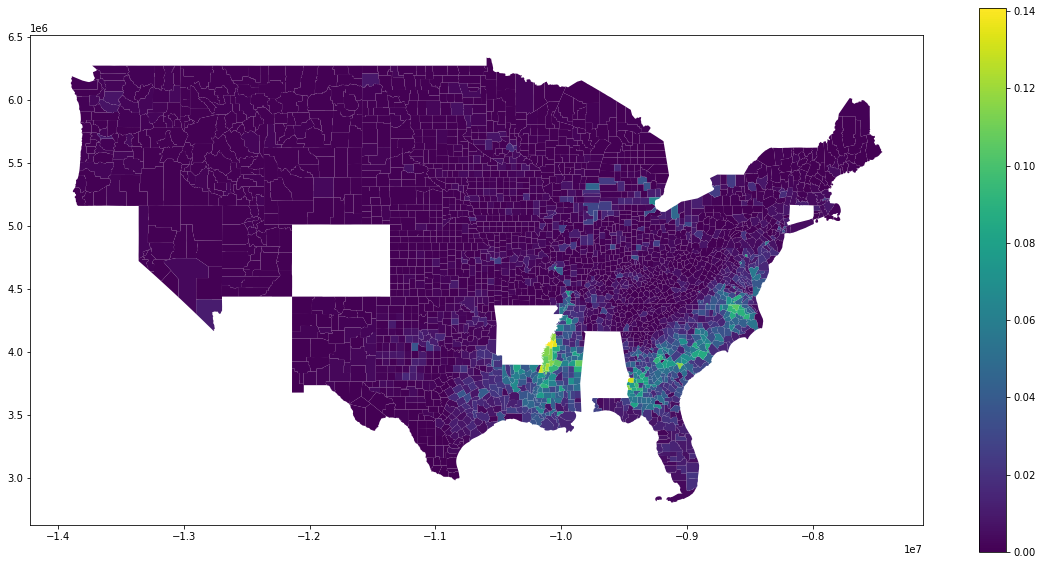

In [34]:
# plot percent SNAP
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('B22005B_002E', legend=True, ax=ax)

<AxesSubplot:>

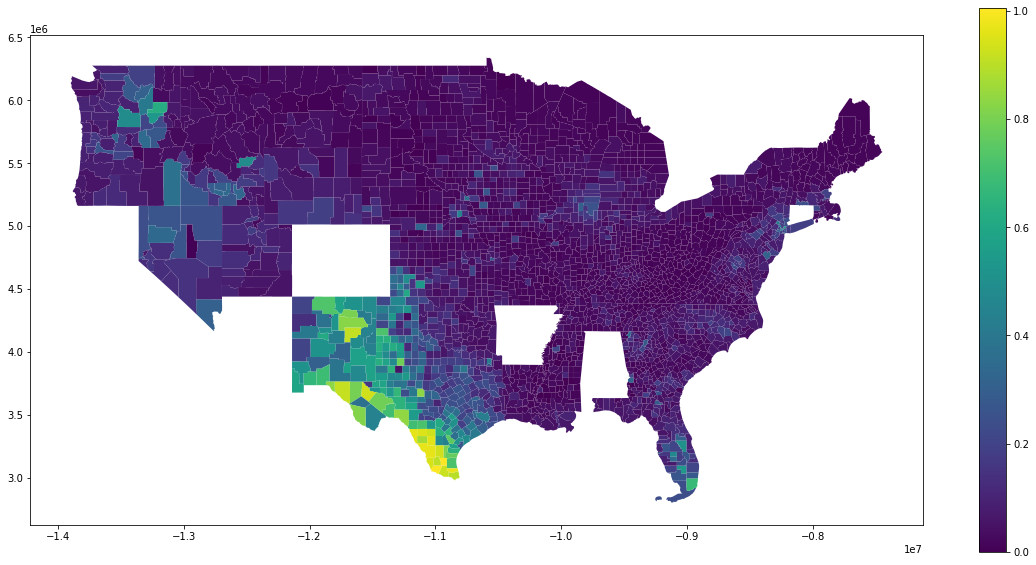

In [35]:
# plot percent hispanic
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('B03002_012E', legend=True, ax=ax)

<AxesSubplot:>

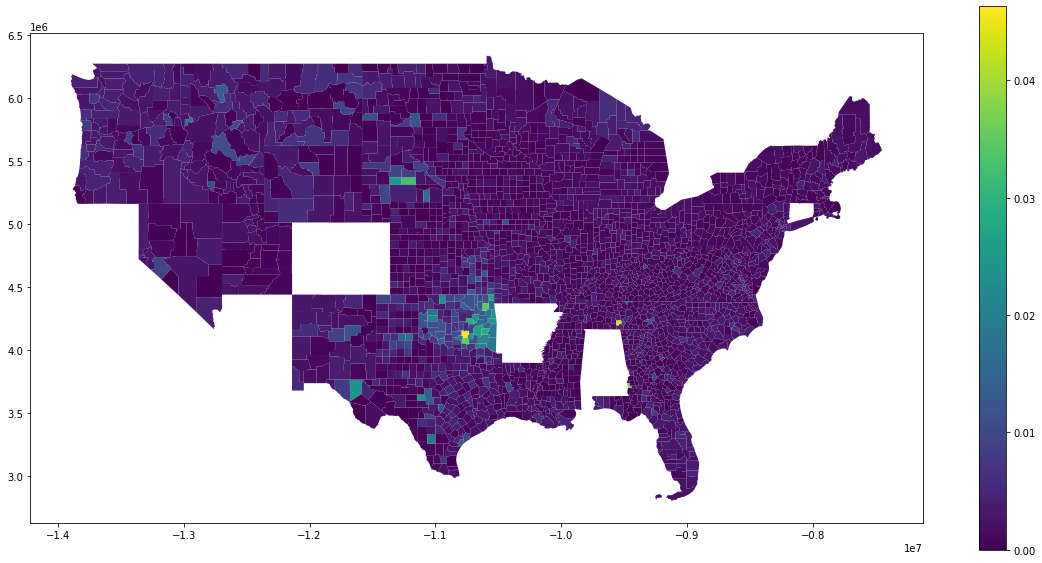

In [36]:
# plot percent no insurance
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('C27001G_007E', legend=True, ax=ax)

In [37]:
# check collinearity using pairwise Pearson's correlation coefficient
counties[cols[:-1]].corr()

B25099_001E  B16010_041E  B22005B_002E  B03002_012E  \
B25099_001E      1.000000     0.754114     -0.207436     0.016483   
B16010_041E      0.754114     1.000000     -0.123159    -0.061930   
B22005B_002E    -0.207436    -0.123159      1.000000    -0.085298   
B03002_012E      0.016483    -0.061930     -0.085298     1.000000   
C27001G_007E    -0.065583    -0.023559     -0.029084     0.106215   

              C27001G_007E  
B25099_001E      -0.065583  
B16010_041E      -0.023559  
B22005B_002E     -0.029084  
B03002_012E       0.106215  
C27001G_007E      1.000000

<div class="alert alert-block alert-success">
       Exercise 3.1: There is moderate-to-high collinearity (r=0.75) between income (B25099_001E) and education (B16010_041E), so we will not include the income variable moving forward, since they largely contain similar information. Next, create a Queen contiguity-based spatial weight matrix for the counties and assign it to a variable named 'w'. Use spatial weight matrix to compute Moran's I for percent obesity and each of the remaining explanatory variables. Do all of the surfaces have stasticically significant positive spatial autocorrelation?

</div>

In [38]:
#variable definitions

# B25099_001E = median household income 
# B16010_041E = total population w/ bachelor degree or higher
# B22005B_002E = individuals enrolled in Supplemental Nutrition Assistance Program (SNAP) within last 12 months
# B03002_012E = total population identifying as Hispanic
# C27001G_007E = individuals 18-64 w/o health insurance
# B25026_001E = total population

# create Queen spatial weight matrix
w = sw.Queen.from_dataframe(counties)

In [39]:
w

In [40]:
# Morans I for percent obesity
m_obesity = Moran(counties['Percentage'], w)
print(m_obesity.I, m_obesity.p_sim)

0.3201420119891 0.001


In [41]:
# Morans I for education
m_education = Moran(counties['B16010_041E'], w)
print(m_education.I, m_education.p_sim)

0.4476049397900987 0.001


In [42]:
# Morans I for SNAP
m_snap = Moran(counties['B22005B_002E'], w)
print(m_snap.I, m_snap.p_sim)

0.72604742795869 0.001


In [43]:
# Morans I for hispanic
m_hispanic = Moran(counties['B03002_012E'], w)
print(m_hispanic.I, m_hispanic.p_sim)

0.809508447659045 0.001


In [44]:
# Morans I for no insurance
m_noins = Moran(counties['C27001G_007E'], w)
print(m_noins.I, m_noins.p_sim)

0.40632010123248957 0.001


### Do all of the surfaces have statistically significant positive spatial autocorrelation?

Yes, all of the surfaces have statistically significant positive spatial autocorrelation. All of the p-values are less than 0.05, and Moran's I returned positive values for spatial autocorrelation for all variables.

<div class="alert alert-block alert-success">
       Exercise 3.2: Compute local Moran's I for percent obesity and plot the hot spots and cold spots on a single map. Where are the cold spots the most prominent and where are the hotspots the most prominent?
</div>

In [45]:
# compute local Moran's I for percent obesity
mloc_obesity = Moran_Local(counties['Percentage'], w)
print(mloc_obesity.Is, mloc_obesity.p_sim)

[ 0.06001245 -0.29748397 -0.01829611 ... -0.06903618 -0.00388246
  0.23538123] [0.419 0.251 0.221 ... 0.311 0.5   0.268]


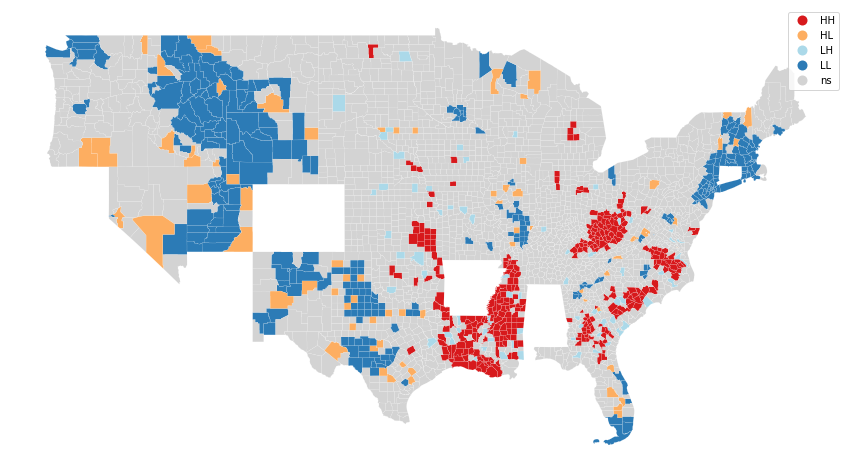

In [46]:
# plot hot spots and cold spots
lisa_cluster(mloc_obesity, counties, p=0.05, figsize = (15,15))
plt.show()

### Where are the cold spots the most prominent and where are the hotspots the most prominent?

The cold spots are most prominent in the mid-northwest U.S., by Idaho, Montana, Wyoming, and Utah. There is also a notable cluster of cold spots in the northeast U.S., which involves New Hampshire, Vermont, the east coast of New York, and Rhode Island.

Hotspots are most prominent in the southern U.S. by Louisiana and Mississippi, and in Kentucky. Other notable clusters fall in the southeastern U.S. as well, including North Carolina, South Carolina, and Georgia.

## Exercise 4: Global non-spatial regression (ordinary least-squares) (5 points)

<div class="alert alert-block alert-success">
       Exercise 4.1: Regress education on obesity (obesity~education) using ordinary least-squares (ols). Then extract the residuals and map them. Conventional OLS Regression assumes that the residuals will be independent and identically distributed (i.i.d.), which means there should not be any (spatial) autocorrelation. Does the plot of the residuals appear to be spatially patterned? Confirm your suspicions by computing Moran's I, local Moran's I, and plotting potential hot spots and cold spots - does this evidence support your initial suspicions? If there are hot spots and cold spots, how do they compare to those from the percent obesity dependent variable?
</div>

In [71]:
# regress education on obesity

# B25099_001E = median household income 
# B16010_041E = total population w/ bachelor degree or higher
# B22005B_002E = individuals enrolled in Supplemental Nutrition Assistance Program (SNAP) within last 12 months
# B03002_012E = total population identifying as Hispanic
# C27001G_007E = individuals 18-64 w/o health insurance
# B25026_001E = total population

data = counties[['Percentage', 'B16010_041E', 'B22005B_002E', 'B03002_012E', 'C27001G_007E']]
data = (data - data.mean()) / data.std()

model = smf.ols('Percentage~B16010_041E', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Percentage   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     902.1
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          3.43e-172
Time:                        00:15:00   Log-Likelihood:                -3610.7
No. Observations:                2821   AIC:                             7225.
Df Residuals:                    2819   BIC:                             7237.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.269e-15      0.016   7.74e-14      1.000      -0.032       0.032
B16010_041E    -0.4924      0.016    -30.035      0.000      -0.525      -0.460
==============================================================================
Omnibus:                       25.367   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.156
Skew:                           0.042   Prob(JB):                     3.14e-09
Kurtosis:                       3.571   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1


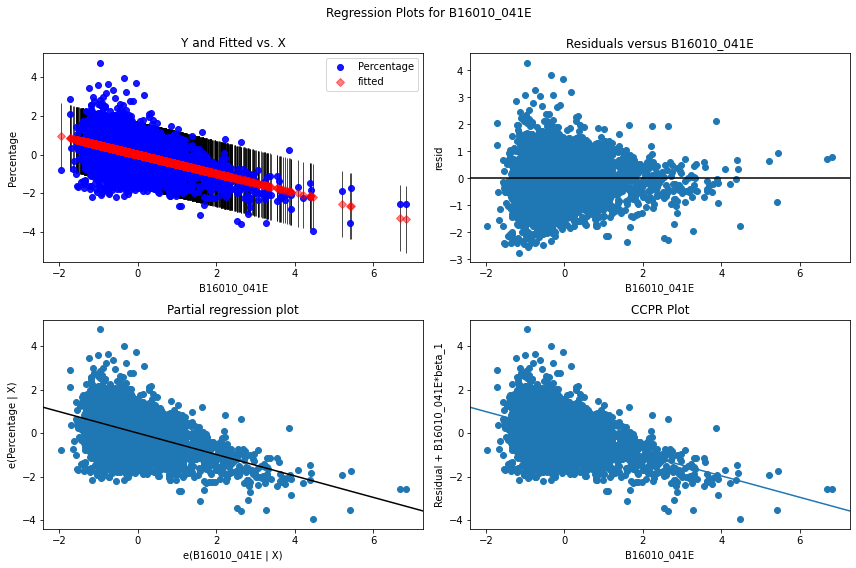

In [72]:
# plot the residuals
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'B16010_041E', fig=fig)

<AxesSubplot:>

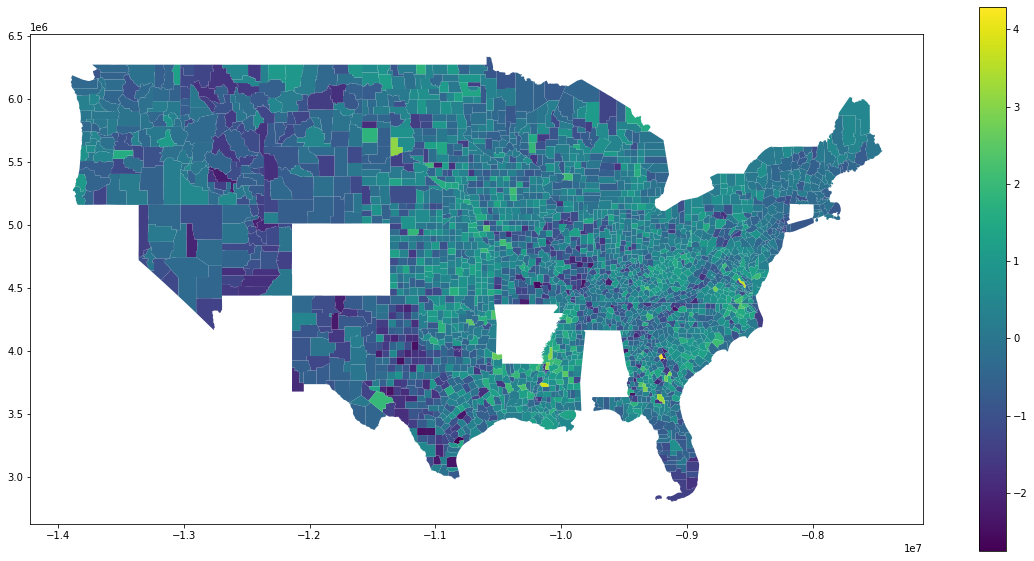

In [73]:
# plot the residuals
counties['resid'] = model.resid
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('resid', legend=True, ax=ax)

In [74]:
# compute Moran's I on the residuals
m_resid = Moran(counties['resid'], w)
print(m_resid.I, m_resid.p_sim)

0.2609985648215785 0.001


In [75]:
# compute local Moran's I on the residuals and plot hot spots and cold spots
mloc_resid = Moran_Local(counties['resid'], w)
print(mloc_resid.Is, mloc_resid.p_sim)

[-0.11687314 -0.34203604  0.058676   ...  0.10637908  0.14319626
  0.44331003] [0.335 0.263 0.42  ... 0.433 0.128 0.101]


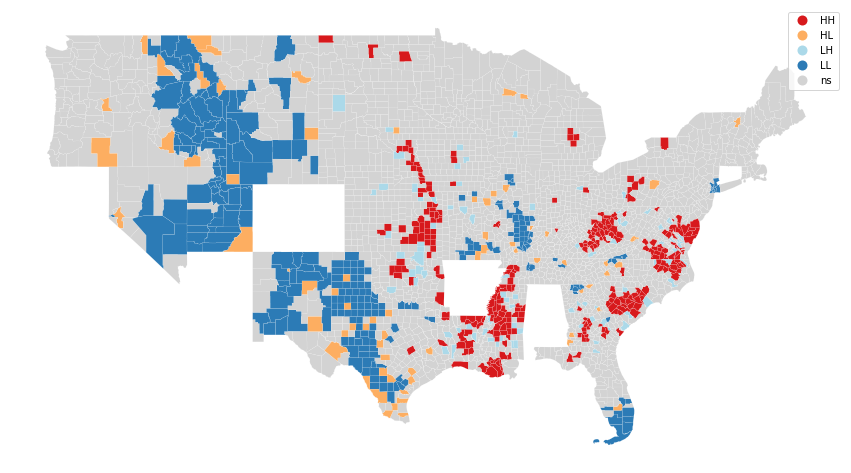

In [76]:
# plot hot spots and cold spots
lisa_cluster(mloc_resid, counties, p=0.05, figsize = (15,15))
plt.show()

### Does the plot of the residuals appear to be spatially patterned? Confirm your suspicions by computing Moran's I, local Moran's I, and plotting potential hot spots and cold spots - does this evidence support your initial suspicions? If there are hot spots and cold spots, how do they compare to those from the percent obesity dependent variable?

The plot of the residuals appears to cluster. Moran's I suggest there is clustering present in the data, with a statistically signficant p-value (which means we can reject the null hypothesis; the data does not exhibit perfectly random dispersion. On the contrary, Local Moran's I returns values indicative of clustering, but p-values are not all statistically significant. However, with Local Moran's I, the interpretation of statistical significance is not the same as for (global) Moran's I, and plotting the cold and hot spots provide greater insight to interpret the residuals. In this case, there are indeed cold spots and hot spots. These clusters spatially align closely with those of the obesity percentage dependent variable.

<div class="alert alert-block alert-success">
       Exercise 4.2: Repeat exercise 4.1 but now regress education, SNAP, hispanic, and, insurance on obesity. How do the results compare? Is there still residual spatial autocorrelation? If so, now how do the hot spots and cold spots compare to those from the percent obesity dependent variable?
</div>

In [118]:
# regress education, SNAP, hispanic, and, insurance on obesity

model = smf.ols('Percentage~B16010_041E+B22005B_002E+B03002_012E+C27001G_007E', data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Percentage   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     337.5
Date:                Thu, 04 Nov 2021   Prob (F-statistic):          1.51e-237
Time:                        02:58:04   Log-Likelihood:                -3449.9
No. Observations:                2821   AIC:                             6910.
Df Residuals:                    2816   BIC:                             6940.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.295e-15      0.015   8.36e-14      1.000      -0.030       0.030
B16010_041E     -0.4757      0.016    -30.381      0.000      -0.506      -0.445
B22005B_002E     0.2135      0.016     13.612      0.000       0.183       0.244
B03002_012E     -0.1734      0.016    -11.064      0.000      -0.204      -0.143
C27001G_007E     0.0478      0.016      3.063      0.002       0.017       0.078
==============================================================================
Omnibus:                       24.587   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.989
Skew:                          -0.073   Prob(JB):                     1.53e-08
Kurtosis:                       3.534   Cond. No.                         1.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

eval_env: 1


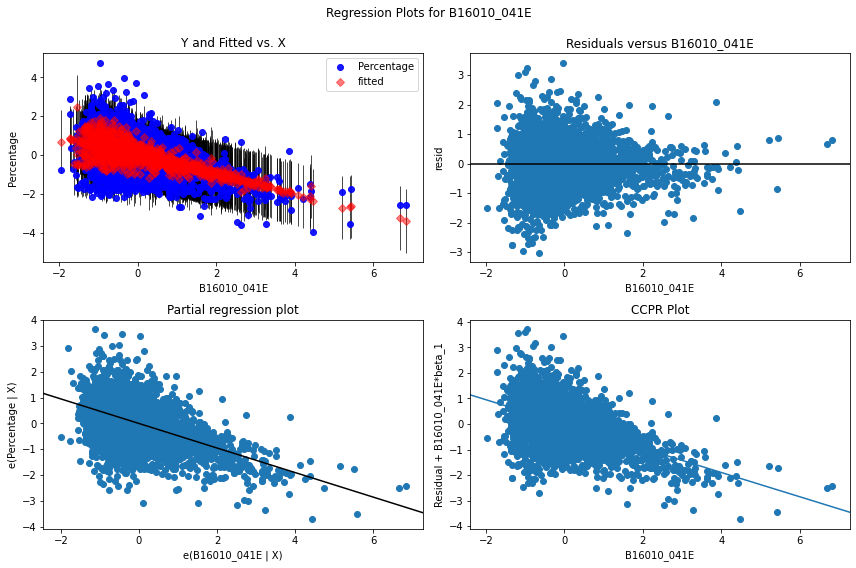

In [120]:
# plot the residuals
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'B16010_041E', fig=fig)

eval_env: 1


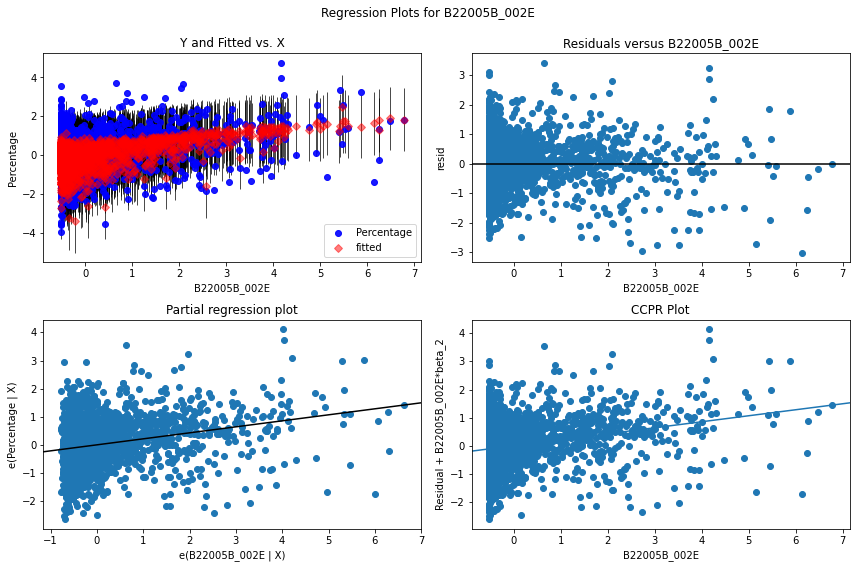

In [121]:
# plot the residuals
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'B22005B_002E', fig=fig)

eval_env: 1


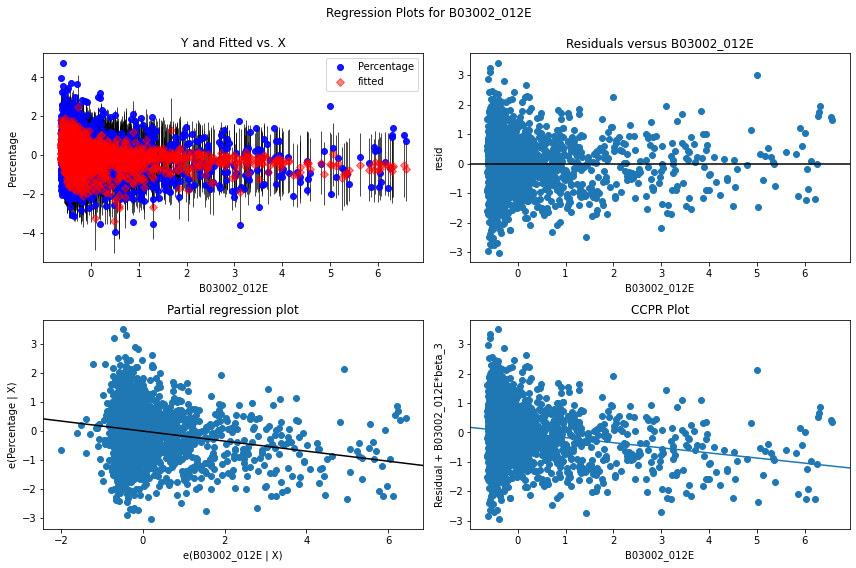

In [122]:
# plot the residuals
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'B03002_012E', fig=fig)

eval_env: 1


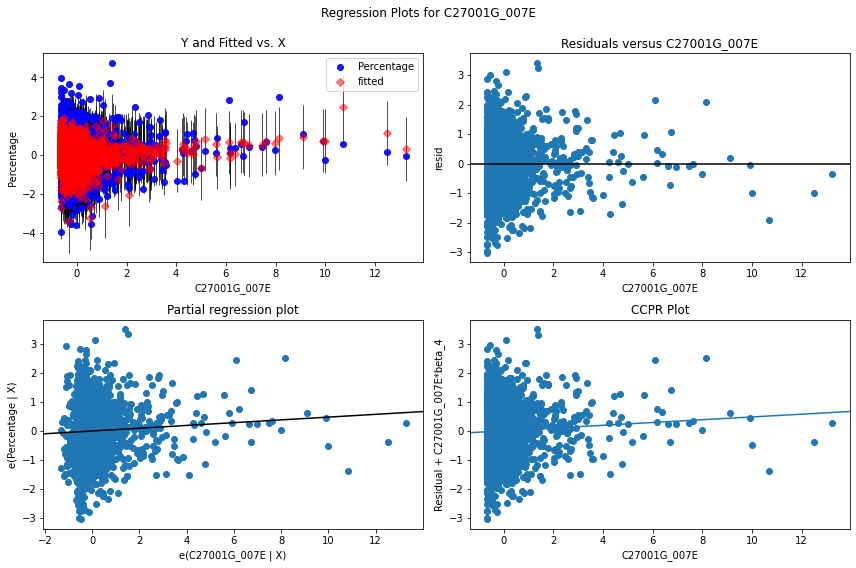

In [123]:
# plot the residuals
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'C27001G_007E', fig=fig)

<AxesSubplot:>

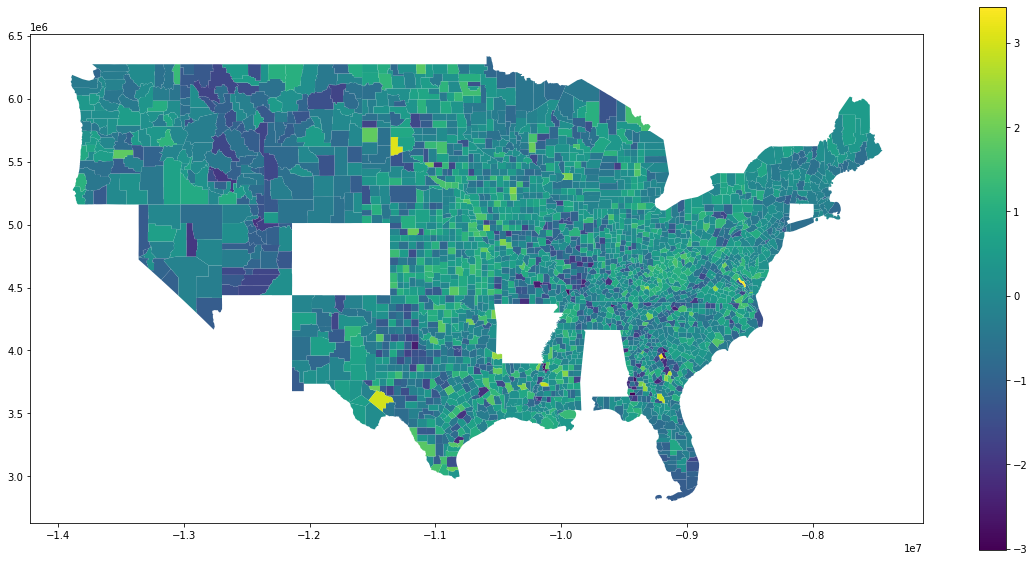

In [78]:
# extract residuals and plot
# plot the residuals
counties['resid'] = model.resid
fig, ax = plt.subplots(figsize=(20,10))
counties.plot('resid', legend=True, ax=ax)

In [79]:
# compute Moran's I on the residuals
m_resid = Moran(counties['resid'], w)
print(m_resid.I, m_resid.p_sim)

0.17061508316390764 0.001


In [80]:
# compute local Moran's I on the residuals and plot hot spots and cold spots
mloc_resid = Moran_Local(counties['resid'], w)
print(mloc_resid.Is, mloc_resid.p_sim)

[-0.14459076 -0.41318406  0.02397631 ...  0.07303115  0.17575462
  0.16764748] [0.301 0.208 0.449 ... 0.45  0.145 0.289]


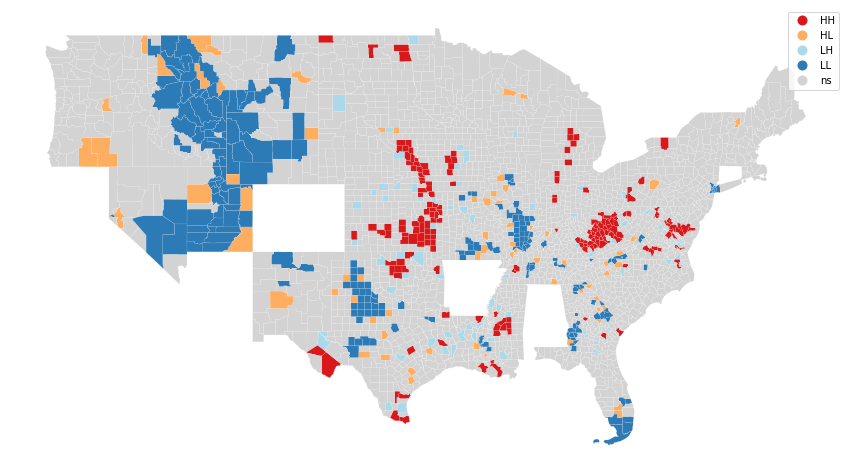

In [81]:
# plot hot spots and cold spots
lisa_cluster(mloc_resid, counties, p=0.05, figsize = (15,15))
plt.show()

### How do the results compare? Is there still residual spatial autocorrelation? If so, now how do the hot spots and cold spots compare to those from the percent obesity dependent variable?

The plot of the residuals appears to be clustered. There appears to still be some residual spatial autocorrelation, but not as much as with education alone regressed on obesity. Spatially, the hot spots and cold spots appear in the same areas. There are slightly less cold spots here, and much less hot spots. In fact, in the southeast U.S., most of the hot spots present in education~obesity are no longer present in this regression.

<div class="alert alert-block alert-success">
       Exercise 4.3: Let's extract our variables from our dataframe to organize them as the endogenous dependent variable (y) vector and the exogenous explanatory variables (X) matrix. This is the typical format for regression tools in PySAL. We also want to center (mean = 0) and scale (var = 1) our variables. This is useful for OLS because it allows us to interpret the coefficient estimates in relation to each other (relative magnitudes). Otherwise the coefficient estimates may have vastly different magnitudes/scales (very small for large X and very large for small X) that cannot be compared to each other. This is also useful/necessary for MGWR because we want the bandwidth estimates to reflect variation in only the process (coefficients) and not the different magnitudes/scales of the data. Next, calibrate an OLS regression for all of our selected variables using PySAL's OLS functionality because it provides important diagnostics. Interpret the resulting coefficient estimates from most influential to least influential, direction of relationship (positive/negative) and statistical significance at the 95% confidence interval.
</div>

In [83]:
counties.columns

Index(['MTFCC', 'OID', 'GEOID', 'STATE', 'COUNTY', 'COUNTYNS', 'BASENAME',
       'NAME', 'LSADC', 'FUNCSTAT', 'COUNTYCC', 'AREALAND', 'AREAWATER',
       'OBJECTID', 'CENTLAT', 'CENTLON', 'INTPTLAT', 'INTPTLON', 'geometry',
       'CountyFIPS', 'County', 'State', 'Percentage', 'Lower Limit',
       ' Upper Limit', 'B25099_001E', 'B16010_041E', 'B22005B_002E',
       'B03002_012E', 'C27001G_007E', 'B25026_001E', 'state', 'county',
       'resid'],
      dtype='object')

In [85]:
#reorganize data

names = ['Percentage']
codes = ['B16010_041E', 'B22005B_002E', 'B03002_012E', 'C27001G_007E']

y = counties[names].values.reshape((-1,1))
X = counties[codes].values

In [86]:
#center and scale data

X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean(axis=0)) / y.std(axis=0)

In [87]:
#calibrate OLS using PySAL

ols_results = spreg.OLS(counties[['Percentage']].values, counties[codes].values, w, spat_diag=True, name_x=codes)
print(ols_results.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        2821
Mean dependent var  :     32.9945                Number of Variables   :           5
S.D. dependent var  :      5.1883                Degrees of Freedom    :        2816
R-squared           :      0.3241
Adjusted R-squared  :      0.3231
Sum squared residual:   51312.018                F-statistic           :    337.4984
Sigma-square        :      18.222                Prob(F-statistic)     :  1.511e-237
S.E. of regression  :       4.269                Log likelihood        :   -8094.451
Sigma-square ML     :      18.189                Akaike info criterion :   16198.903
S.E of regression ML:      4.2649                Schwarz criterion     :   16228.627

-----------------------------------------------------------------------------

### interpret the resulting coefficient estimates by editing the list below

*variable definitions*

* B16010_041E = total population w/ bachelor degree or higher
* B22005B_002E = individuals enrolled in Supplemental Nutrition Assistance Program (SNAP) within last 12 months
* B03002_012E = total population identifying as Hispanic
* C27001G_007E = individuals 18-64 w/o health insurance

**most influential: pos/neg, sig? --> least influential: pos/neg, sig?**
1. Most influential explanatory variable: individuals 18-64 w/o health insurance, at a positive correlation (74.308), and significant p-value (0.002).
2. Individuals enrolled in SNAP within last 12 months, positive correlation (57.487), and significant p-value (0.0000000)
3. Total population w/ bachelor degree or higher, negative correlation (-40.577), and significant p-value (0.000000)
4. Least influential: Total population identifying as Hispanic, negative correlation (-6.457), and significant p-value (0.0000000)


The greater the number of people without health insurance or the greater the number of people enrolled in SNAP, the higher the percent obesity. The lower the number of people with a bachelor's degree or higher, or the lower the number of people identifying as Hispanic, the higher the percent obesity. Health insurance status and SNAP enrollment have a stronger relationship to obesity. Education and people identifying as Hispanic have statistically significant relationships to obesity, however they demonstrate a negative association where an increase in these variables leads to a decrease in obesity.

## Exercise 5: Global spatial regression (4 points)

<div class="alert alert-block alert-success">
               Exercise 5.1: Two popular (global) spatial regression specifications are the spatial lag model and the spatial error model. The spatial lag model incorporates an autoregressive process (spatial lag of y) directly into the estimator (not just as an additional variable). This specification is motivated by a process where the value at each location is directly dependent upon neighboring values (think house prices). In contrast, the spatial error model incorporates an autoregressive process in the error term to filter out the autocorrelation in the residuals (perhaps because we are missing an important variable). An important question is: which specification should we use? Sometimes theory may guide us (like house prices), but it is not always clear and so we can rely on diagnostic tests for spatial dependence. The Lagrange Multiplier provides evidence towards one specification or the other. Notice above in the OLS summary that Lagrange Multiplier (lag) = 262.027 and Lagrange Multiplier (error) = 282.079. Since 282.079 > 262.027 this provides evidence for the error model over the lag model. However, Lagrange Multiplier (SARMA) = 295.819 also suggests a combo lag/error model may be the most appropriate, though this outside the scope of this lab. Another important question is: how do the lag/error model results differ? To examine this, lets calibrate each model.
</div>

In [92]:
#calibrate lag model

lag = spreg.ML_Lag(counties['Percentage'].values, counties[codes].values, w, name_x=codes)
print(lag.summary)

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        2821
Mean dependent var  :     32.9945                Number of Variables   :           6
S.D. dependent var  :      5.1883                Degrees of Freedom    :        2815
Pseudo R-squared    :      0.3727
Spatial Pseudo R-squared:  0.3207
Sigma-square ML     :      16.889                Log likelihood        :   -8013.871
S.E of regression   :       4.110                Akaike info criterion :   16039.741
                                                 Schwarz criterion     :   16075.410

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [93]:
#calibrate error model

error = spreg.ML_Error(counties['Percentage'].values, counties[codes].values, w, name_x=codes)
print(error.summary)

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:        2821
Mean dependent var  :     32.9945                Number of Variables   :           5
S.D. dependent var  :      5.1883                Degrees of Freedom    :        2816
Pseudo R-squared    :      0.3226
Sigma-square ML     :      16.616                Log likelihood        :   -8002.403
S.E of regression   :       4.076                Akaike info criterion :   16014.806
                                                 Schwarz criterion     :   16044.531

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

<div class="alert alert-block alert-success">
               Exercise 5.2: There are two primary differences between the lag/error model results. (1) How we interpret the autoregressive parameter: In the error model, the autoregressive parameter (lamba) does not have an additional interpretation and is therefore sometimes referred to as a 'nuisance' parameter. In contrast, the autoregressive parameter in the lag model (W_dep_var) also denotes what are called spillover effects. Spillover effects encapsulate the idea that each relationship in the model is no longer independent. That is, if you change a single explanatory variable value at one location, it not only affects the dependent variable at that location, but also the dependent variable at the neighboring locations. These are called indirect effects in comparison to the classic interpretation of coefficients as the direct effects. An example of this is demonstrated below where you can see some sizable differences in coefficient estimate magnitudes after accounting for the indirect (spillover) effects. (2) The danger in using OLS instead of the correct spatial regression. For the spatial lag model we typically expect that some of the coefficient estimates will be statistically different from those obtained through OLS, especially after Incorporating the spillover effects. In contrast, we do not expect this to be true in the spatial error model. For example, if you compute the 95% confidence intervals for the coefficient estimates from the spatial lag model, you might see that some do not overlap with those from the 95% confidence intervals for the OLS results. This is not true for the error model – we would not typically see that the 95% confidence intervals for the coefficient estimates from the spatial error model overlap with The 95% confidence intervals for the OLS results. Compute the 95% confidence intervals for the coefficient estimates from the three models (ols, lag, error). How many intervals overlap between the ols and lag models? How many intervals overlap between the ols and error models? Hint: can 95% confidence interval can be computed as (estimate - 1.96 \* stand_error, estimate + 1.96 \* stand_error).

In [94]:
#direct and indirect effects from the lag model

b=lag.betas[:-1]
rho=lag.betas[-1]
btot=b/(float(1)-rho)
bind=btot-b

full_eff=pd.DataFrame(np.hstack([b,bind,btot]),index=['CONSTANT']+codes, columns=['Direct','Indirect','Total'])
full_eff

Direct   Indirect      Total
CONSTANT      27.902391  12.081976  39.984367
B16010_041E  -34.764679 -15.053405 -49.818085
B22005B_002E  41.071569  17.784343  58.855912
B03002_012E   -4.429111  -1.917843  -6.346954
C27001G_007E  66.114653  28.628214  94.742867

Compute the 95% confidence intervals for the coefficient estimates from the three models (ols, lag, error). 

In [125]:
# OLS

d = {'variable': ['Constant', 'B16010_041E', 'B22005B_002E', 'B03002_012E', 'C27001G_007E'], 'coefficient': [38.7276178, -40.5770161, 57.4874712, -6.4566597, 74.3081811], 'std_error': [0.2353942, 1.3355916, 4.2233581, 0.5835565, 24.2563575]}

ci_ols = pd.DataFrame(data=d)

ci_ols

variable  coefficient  std_error
0      Constant    38.727618   0.235394
1   B16010_041E   -40.577016   1.335592
2  B22005B_002E    57.487471   4.223358
3   B03002_012E    -6.456660   0.583557
4  C27001G_007E    74.308181  24.256358

In [126]:
# OLS 

ci_ols['ci_lower'] = ci_ols['coefficient'] - 1.96 * ci_ols['std_error']
ci_ols['ci_upper'] = ci_ols['coefficient'] + 1.96 * ci_ols['std_error']

In [127]:
# OLS

ci_ols

variable  coefficient  std_error   ci_lower    ci_upper
0      Constant    38.727618   0.235394  38.266245   39.188990
1   B16010_041E   -40.577016   1.335592 -43.194776  -37.959257
2  B22005B_002E    57.487471   4.223358  49.209689   65.765253
3   B03002_012E    -6.456660   0.583557  -7.600430   -5.312889
4  C27001G_007E    74.308181  24.256358  26.765720  121.850642

In [128]:
# Lag model

d_lag = {'variable': ['Constant', 'B16010_041E', 'B22005B_002E', 'B03002_012E', 'C27001G_007E'], 
         'coefficient': [27.9023912, -34.7646793, 41.0715692, -4.4291107, 66.1146528], 
         'std_error': [0.8933186, 1.3960738, 4.2403843, 0.5769404, 23.3714954]}
ci_lag = pd.DataFrame(data=d_lag)
ci_lag['ci_lower'] = ci_lag['coefficient'] - 1.96 * ci_lag['std_error']
ci_lag['ci_upper'] = ci_lag['coefficient'] + 1.96 * ci_lag['std_error']
ci_lag

variable  coefficient  std_error   ci_lower    ci_upper
0      Constant    27.902391   0.893319  26.151487   29.653296
1   B16010_041E   -34.764679   1.396074 -37.500984  -32.028375
2  B22005B_002E    41.071569   4.240384  32.760416   49.382722
3   B03002_012E    -4.429111   0.576940  -5.559914   -3.298308
4  C27001G_007E    66.114653  23.371495  20.306522  111.922784

In [129]:
# Error model

d_err = {'variable': ['Constant', 'B16010_041E', 'B22005B_002E', 'B03002_012E', 'C27001G_007E'], 
         'coefficient': [38.6413226, -40.6219553, 51.7227566, -5.1675883, 74.7524016], 
         'std_error': [0.2774532, 1.4841915, 5.3087847, 0.7711387, 26.3747096]}
ci_err = pd.DataFrame(data=d_err)
ci_err['ci_lower'] = ci_err['coefficient'] - 1.96 * ci_err['std_error']
ci_err['ci_upper'] = ci_err['coefficient'] + 1.96 * ci_err['std_error']
ci_err

variable  coefficient  std_error   ci_lower    ci_upper
0      Constant    38.641323   0.277453  38.097514   39.185131
1   B16010_041E   -40.621955   1.484192 -43.530971  -37.712940
2  B22005B_002E    51.722757   5.308785  41.317539   62.127975
3   B03002_012E    -5.167588   0.771139  -6.679020   -3.656156
4  C27001G_007E    74.752402  26.374710  23.057971  126.446832

### How many intervals overlap between the ols and lag models? 

Three intervals overlap: B22005B_002 (SNAP), B03002_012E (Identify as Hispanic), and C27001G_007E (No health insurance).

### How many intervals overlap between the ols and error models? 

All four intervals overlap (Education, SNAP, Hispanic, Insurance).

<div class="alert alert-block alert-success">
               Exercise 5.3: Finally, create a map of the residuals from the lag model and the error model and also calculate the Moran's I values, and map the hot and cold spots from local Moran's I. Does there appear to be any residual spatial autocorrelation? Hint: the model residuals are the 'u' attribute in the lag and error models.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


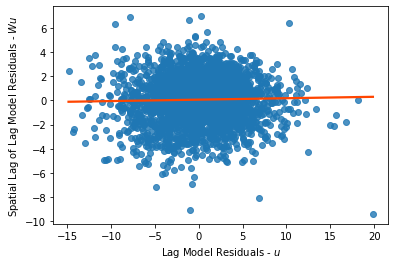

In [106]:
# extract residuals and plot them for counties (lag model)

lag_residual = sw.spatial_lag.lag_spatial(w, lag.u)
counties['resid_lag'] = lag_residual
ax = seaborn.regplot(lag.u.flatten(), lag_residual.flatten(), 
                     line_kws=dict(color='orangered'),
                     ci=None)
ax.set_xlabel('Lag Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Lag Model Residuals - $W u$');

In [107]:
#Moran's I for the residuals from the lag model
m_lag = Moran(counties['resid_lag'], w)
print(m_lag.I, m_lag.p_sim)

0.42565547988851304 0.001


In [110]:
#Local Moran's I for the residuals from the lag model
mloc_lag = Moran_Local(counties['resid_lag'], w)
print(mloc_lag.Is, mloc_lag.p_sim)

[-0.40492867 -0.29397976  0.07055082 ... -0.01737809  0.49571837
  0.17026598] [0.051 0.203 0.189 ... 0.04  0.018 0.014]


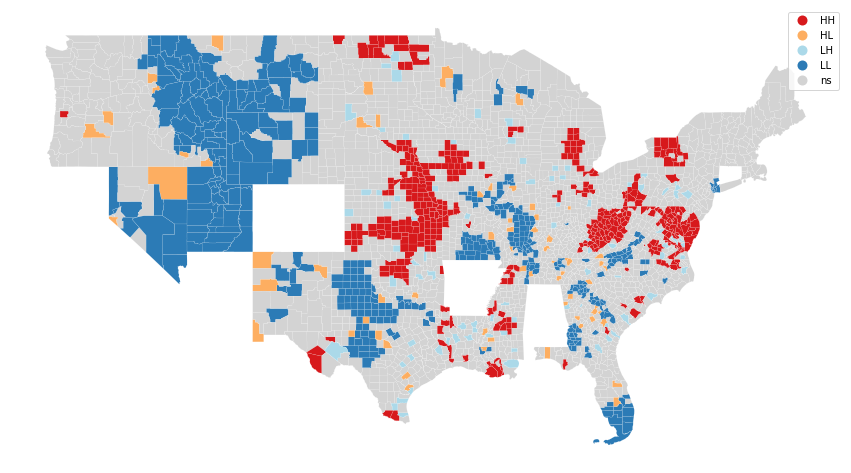

In [111]:
# hot and cold spots
lisa_cluster(mloc_lag, counties, p=0.05, figsize = (15,15))
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


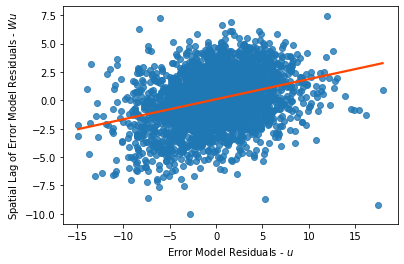

In [113]:
# extract residuals and plot them for counties (error model)

err_residual = sw.spatial_lag.lag_spatial(w, error.u)
counties['resid_err'] = err_residual
ax = seaborn.regplot(error.u.flatten(), err_residual.flatten(), 
                     line_kws=dict(color='orangered'),
                     ci=None)
ax.set_xlabel('Error Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of Error Model Residuals - $W u$');

In [115]:
#Moran's I for the residuals from the error model
m_lag = Moran(counties['resid_err'], w)
print(m_lag.I, m_lag.p_sim)

0.6448695392642679 0.001


In [116]:
#Local Moran's I for the residuals from the error model
mloc_err = Moran_Local(counties['resid_err'], w)
print(mloc_err.Is, mloc_err.p_sim)

[-0.23943137 -0.15182985  0.0118785  ...  0.08413125  0.48919409
  0.56777347] [0.038 0.306 0.342 ... 0.061 0.034 0.008]


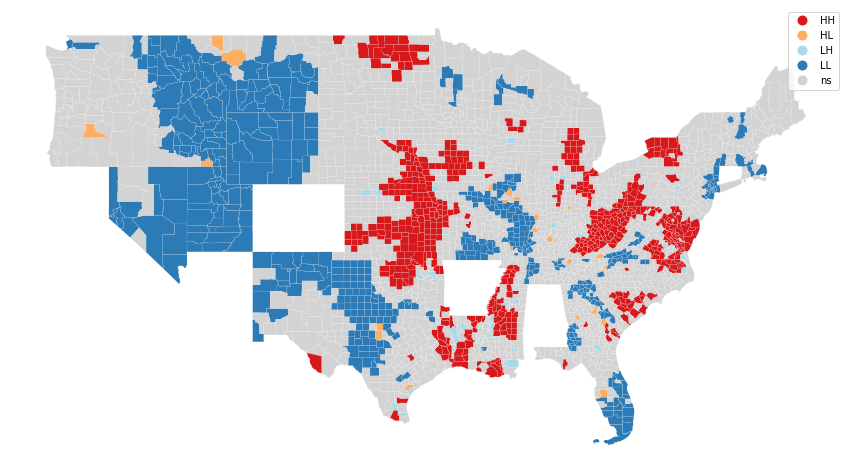

In [117]:
# hot and cold spots
lisa_cluster(mloc_err, counties, p=0.05, figsize = (15,15))
plt.show()

### Does there appear to be any residual spatial autocorrelation?

Yes, there appears to be residual SA. In both lag and error models, Moran's I and local Moran's I both return values that suggest clustering with significant p-values (<0.05). Mapping the cold and hot spot visually supports this conclusion.

## Exercise 6: Geographically weighted regression (4 points)

<div class="alert alert-block alert-success">
       Exercise 6.1: Even though the results above for the global spatial regression models suggested the use of an error model over a lag model, the analysis of the residual spatial autocorrelation suggests that further analysis might be necessary. It might be useful to consider different types of spatial weight matrices or perhaps to investigate spatial heterogeneity in the processes. This is where GWR/MGWR comes in. First we need to extract the coordinates for the centroids from the county geometries. After this is done, calibrate a GWR and MGWR model. How do the selected bandwidths differ between the two models? Is the GWR bandwidth larger or smaller than the MGWR bandwidths?
</div>

In [130]:
# extract the coordinates for the centroids from the county geometries

counties['X'] = counties.apply(lambda row: row.geometry.centroid.coords[0][0], axis=1)
counties['Y'] = counties.apply(lambda row: row.geometry.centroid.coords[0][1], axis=1)
c_y = counties['Percentage'].values.reshape((-1,1))
c_x = counties[['B25099_001E', 'B16010_041E', 'B22005B_002E', 'B03002_012E', 'C27001G_007E']].values
u = counties['X']
v = counties['Y']
coords = list(zip(u,v))

In [131]:
#Calibrate GWR

gwr_selector = Sel_BW(coords, c_y, c_x)
gwr_bw = gwr_selector.search()
print(gwr_bw)
gwr_model = GWR(coords, c_y, c_x, gwr_bw)
gwr_results = gwr_model.fit()

/opt/conda/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.00861e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.04195e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.36134e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=9.81849e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.08698e-16): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/opt/conda/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix 

302.0


In [132]:
print(gwr_results.resid_ss)

41805.93229584311


In [ ]:
#Calibrate MGWR - this will take around 20 to 30 minutes...Feel free To take a break with some coffee or tea!

mgwr_selector = Sel_BW(coords, c_y, c_x, multi=True)
mgwr_bw = mgwr_selector.search()
print(mgwr_bw)
mgwr_model = MGWR(coords, c_y, c_x, mgwr_selector)
mgwr_results = mgwr_model.fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

<div class="alert alert-block alert-success">
       Exercise 6.2: Once we have our results we can extract into a Dataframe for visualization. Noticed below that we are using the 'filter_tvals' method to identify statistically insignificant coefficient estimates using the GWR specific hypothesis testing correction for the 95% confidence interval. These are then added to the maps of the results as the great polygons to block out serious patterns. Describe the differences between the surfaces/maps of parameter estimates between GWR and MGWR for each of the explanatory variables.
</div>

In [ ]:
#Add GWR parameters to GeoDataframe
counties['gwr_intercept'] = gwr_results.params[:,0]
counties['gwr_edu'] = gwr_results.params[:,1]
counties['gwr_snap'] = gwr_results.params[:,2]
counties['gwr_hisp'] = gwr_results.params[:,3]
counties['gwr_ins'] = gwr_results.params[:,4]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

#Calibrate MGWR model

#Add MGWR parameters to GeoDataframe
counties['mgwr_intercept'] = mgwr_results.params[:,0]
counties['mgwr_edu'] = mgwr_results.params[:,1]
counties['mgwr_snap'] = mgwr_results.params[:,2]
counties['mgwr_hisp'] = mgwr_results.params[:,3]
counties['mgwr_ins'] = mgwr_results.params[:,4]

#Obtain t-vals filtered based on multiple testing correction
mgwr_filtered_t = mgwr_results.filter_tvals()

kwargs1 = {'edgecolor':'black', 'alpha':.65}
kwargs2 = {'edgecolor':'black'}

compare_surfaces(counties, 'gwr_intercept', 'mgwr_intercept', gwr_filtered_t[:,0],
        gwr_bw, mgwr_filtered_t[:,0], mgwr_bw[0], 'Intercept', kwargs1, kwargs2)

compare_surfaces(counties, 'gwr_edu', 'mgwr_edu', gwr_filtered_t[:,1], 
        gwr_bw, mgwr_filtered_t[:,1], mgwr_bw[1], 'Education', kwargs1, kwargs2)

compare_surfaces(counties, 'gwr_snap', 'mgwr_snap', gwr_filtered_t[:,2], 
        gwr_bw, mgwr_filtered_t[:,2], mgwr_bw[2], 'SNAP', kwargs1, kwargs2)

compare_surfaces(counties, 'gwr_hisp', 'mgwr_hisp', gwr_filtered_t[:,3],
        gwr_bw, mgwr_filtered_t[:,3], mgwr_bw[3], 'Hispanic', kwargs1, kwargs2)

compare_surfaces(counties, 'gwr_ins', 'mgwr_ins', gwr_filtered_t[:,4],
        gwr_bw, mgwr_filtered_t[:,4], mgwr_bw[4], 'Insurance', kwargs1, kwargs2)

In [ ]:
# describe the differences between the maps below

- Intercept:
- Education:
- SNAP:
- Hispanic:
- Insurance:

<div class="alert alert-block alert-success">
       Exercise 6.3: Now let's check the model fit based on the $R^2$ and Akaike Info Criterion (AIC). How does it compare for GWR and MGWR, as well as to the results for OLS and the lag and error models? What does this suggest?

In [ ]:
# model criterion comparison

### OLS:
# R-squared           :      0.3241
# Akaike info criterion :   16198.903

### Lag:
# Pseudo R-squared    :      0.3727
# Akaike info criterion :   16039.741
    
### Error:
# Pseudo R-squared    :      0.3226
# Akaike info criterion :   16014.806

print('R2: ', gwr_results.R2)
print('AIC: ', gwr_results.aic)

<div class="alert alert-block alert-success">
               Exercise 6.4: Finally, create a map of the residuals from the MGWR model and also calculate the Moran's I values, and map the hot and cold spots from local Moran's I. Does there appear to be any residual spatial autocorrelation? Hint: the model residuals are the 'resid_response' attribute in MGWR model.

In [ ]:
# extract residuals and plot them for counties (mgwr model)

mgwr_resid = sw.spatial_lag.lag_spatial(w, mgwr_model.resid_response)
counties['resid_mgwr'] = mgwr_resid
ax = seaborn.regplot(mgwr_model.resid_response.flatten(), mgwr_resid.flatten(), 
                     line_kws=dict(color='orangered'),
                     ci=None)
ax.set_xlabel('MGWR Model Residuals - $u$')
ax.set_ylabel('Spatial Lag of MGWR Model Residuals - $W u$');

In [ ]:
#Moran's I for the residuals from the lag model
m_mgwr = Moran(counties['resid_mgwr'], w)
print(m_mgwr.I, m_mgwr.p_sim)

In [ ]:
# hot and cold spots
lisa_cluster(m_mgwr, counties, p=0.05, figsize = (15,15))
plt.show()

<div class="alert alert-block alert-success">
               Final thoughts: Were there any patterns in the MGWR analysis that were not convincing? If so, please describe them below, along with any other final thoughts, questions, or comments. To conclude, I want to share the concept of *equifinality*. This is the principle whereby a given end state maybe reached by many potential means. In the context of spatial regression, this is important because it means that for a given spatial pattern, it could have been created by multiple different processes. For example, it could have been created by a spatial autoregressive process (house prices) that would that would be best captured by a spatial lag model or it could have been created by spatially heterogeneous processes that would be best captured by GWR/MGWR. In reality, we will never really know and so we need to use a combination of statistical tests, empirical evidence, and theory to guide our decision-making. It is also worth noting that it is also possible to have processes/models that combined aspects of dependence/heterogeneity (global vs local spatial effects), but these become complicated very quickly and bring us into the realms of advanced spatial econometrics and spatial statistics.

In [ ]:
# Final thoughts go here: